Site info from http://dkasolarcentre.com.au/source/alice-springs/dka-m5-b-phase<br><br>
Note that the data now does not report met station data (only power, PR, and some others) and so we will use this older data file from 2018 to do our work.
<br><br>
Array Rating	5.1kW<br>
Panel Rating	170W<br>
Number Of Panels	30<br>
Panel Type	BP 4170N<br>
Array Area	37.8 m²<br>
Type Of Tracker	N/A<br>
Inverter Size / Type	6 kW, SMA SMC 6000A<br>
Installation Completed	Tue, 11 Nov 2008<br>
Array Tilt/Azimuth	Tilt = 20, Azi = 0 <br>
<br>
http://www.solardesigntool.com/components/inverter-grid-tie-solar/SMA/387/SMC-6000A/specification-data-sheet.html<br>
http://www.posharp.com/bp4170n-solar-panel-from-bp-solar_p1153991998d.aspx


In [3]:
import pandas as pd
import pvlib
import matplotlib.pyplot as plt
%matplotlib inline

from ImportData import df # previously imported and calculated data

In [2]:
# Define some of the site info and hardware

module = pvlib.pvsystem.retrieve_sam('SandiaMod')['BP_Solar_BP4170__2003__E__']
inverter = pvlib.pvsystem.retrieve_sam('cecinverter')['SMA_America__SB6000TL_US__240V_']
# not sure if right inverter, exact "SMC" model not listed

meta = {"latitude": -23.762028,
        "longitude": 133.874886,
        "timezone": 'Australia/North',
        "tempco": -0.005,
        "azimuth": 0,
        "tilt": 20,
        "pdc": 5100.0,
        "temp_model": 'open_rack_cell_polymerback',
        "a":-3.56,
        "b":-0.075,
        'delT':3} # a b delT for open rack glass/polymer module model

t_model_params = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']["open_rack_glass_polymer"]  # Also can do like this

In [4]:
# Attempt model chain  

# Dont have info on layout of site, so I'm guessing (based on voltages) 3 strings of 10 panels
system = pvlib.pvsystem.PVSystem(surface_tilt = 20, 
                                 surface_azimuth=0, 
                                 module_parameters=module, 
                                 modules_per_string=10, 
                                 strings_per_inverter=3, 
                                 inverter_parameters=inverter, 
                                 racking_model='open_rack',
                                 temperature_model_parameters=t_model_params)

location = pvlib.location.Location(meta['latitude'],meta['longitude'],name='BP',tz=meta['timezone'])

# This losses model should be improved, but for broad strokes it is better than having no loss model
# When run without losses_model, the energy model over-estimates the power output
mc = pvlib.modelchain.ModelChain(system, 
                                 location,
                                 losses_model='pvwatts')

weather = df[['dni','ghi','dhi','Tcell']].rename(columns = {'Tcell':'cell_temperature'}) # Necessary layout for ModelChain

mc.run_model(weather)
df['ac'] = mc.ac

Text(0, 0.5, 'Modeled Power')

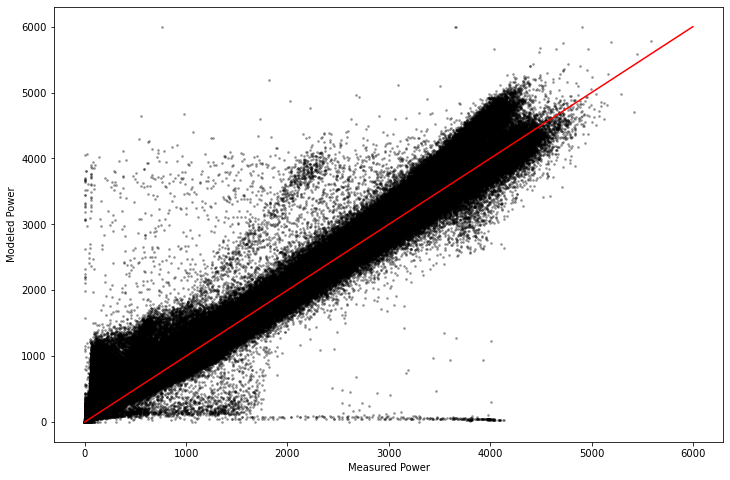

In [5]:
plt.figure(figsize=(12,8))
plt.scatter(df.power, mc.ac, alpha=0.3, s=3, c='k')
plt.plot([0,6000],[0,6000],c='r',label='Equal')
plt.xlabel('Measured Power')
plt.ylabel('Modeled Power')